In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import plotnine as pn
import os
import os.path as osp
import tqdm
from cytokit import config as ck_config
from cytokit.function import data as ck_data

In [4]:
variant_map = {
    '20190703-sta-titration': {'v00': 'cpn-cell-only', 'v01': 'spheroid-cpn-cell', 'v02': 'spheroid-dog-cell'},
    '20190719-co-culture': {'v00': 'spheroid-cpn-cell', 'v01': 'spheroid-dog-cell', 'v02': 'cpn-cell-only'},
    '20190822-co-culture': {'v00': 'spheroid-cpn-cell', 'v01': 'spheroid-dog-cell', 'v02': 'cpn-cell-only'},
    '20190830-co-culture': {'v00': 'spheroid-cpn-cell', 'v01': 'spheroid-dog-cell', 'v02': 'cpn-cell-only'},
    '20191003-co-culture': {'v00': 'spheroid-cpn-cell', 'v01': 'spheroid-dog-cell', 'v02': 'cpn-cell-only'}
}
exp_grps = sorted(list(variant_map.keys()))

def exp_group_dir(exp):
    return osp.join('/lab/data/spheroid', exp)

def exp_group_out_dir(exp):
    return osp.join(exp_group_dir(exp), 'output')
    
def read_results(exp):
    df = pd.read_csv(osp.join('..', exp, 'experiments.csv'))
    
    if exp == '20190703-sta-titration':
        df['rep'] = df['grid'].str.extract('XY(\d+)', expand=False).astype(int)
        df['has_peptide'] = df['cond'].str.match(r'.*\-wp(\-|$)').map({True: 'w/ Peptide', False: 'No Peptide'})
        df['cell_count'] = df['name'].str.extract(r'([\d.]+kT)', expand=False).fillna('0kT')
        df['sta_conc'] = df['name'].str.extract(r'sta-([\d.]+)-20um', expand=False)
    elif exp == '20190719-co-culture':
        df['has_peptide'] = df['cond'].str.match(r'.*\-wp\-.*').map({True: 'w/ Peptide', False: 'No Peptide'})
        df['cell_count'] = df['name'].str.extract(r'([\d.]+mT)', expand=False)
        df['sta_conc'] = df['name'].str.extract(r'([\d.]+)uMsta', expand=False)
    elif exp in ['20190822-co-culture', '20190830-co-culture', '20191003-co-culture']:
        df['has_peptide'] = df['cond'].str.match(r'.*\-wp(\-|$)').map({True: 'w/ Peptide', False: 'No Peptide'})
        df['cell_count'] = df['name'].str.extract(r'([\d.]+kT)', expand=False)
        df['sta_conc'] = df['name'].str.extract(r'([\d.]+)uM', expand=False)
    else:
        raise ValueError('Invalid exp "{}"'.format(exp))
    #df['label'] = df.apply(lambda r: '{}-{}-r{:01d}'.format(r['cell_count'], r['sta_conc'], r['rep']), axis=1)
    #df['key'] = df.apply(lambda r: '{}-{}-{}'.format(r['has_peptide'], r['sta_conc'], r['cell_count']), axis=1)
    df['rep'] = df['rep'].apply(lambda v: 'r{}'.format(v))
    df['grp'] = exp
    
    res = []
    for k, v in variant_map[exp].items():
        dfv = df.copy()
        dfv['variant'] = v
        dfv['variant_num'] = k
        dfv['output_dir'] = dfv.apply(lambda r: osp.join(exp_group_out_dir(exp), r['name'], k), axis=1)
        
        # Filter to experiments with data only and load config
        dfv = dfv[dfv.apply(lambda r: osp.exists(osp.join(r['output_dir'], 'cytometry', 'data.csv')), axis=1)]
        if len(dfv) == 0:
            continue
        dfv['config'] = dfv.apply(lambda r: ck_config.load(osp.join(r['output_dir'], 'config')), axis=1)
        res.append(dfv)
    return pd.concat(res)

df = pd.concat([
    read_results(exp)
    for exp in exp_grps
])

df['sta_conc'] = df['sta_conc'].apply(lambda v: '{:05.3f}uM'.format(float(v)))
df['cell_count'] = df['cell_count'].apply(lambda v: float(v.replace('kT', ''))/1000. if 'kT' in v else float(v.replace('mT', ''))).apply('{:05.2f}mT'.format)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388 entries, 0 to 35
Data columns (total 18 columns):
cell_count     388 non-null object
cond           388 non-null object
conf           388 non-null object
config         388 non-null object
dir            388 non-null object
grid           388 non-null object
grp            388 non-null object
has_peptide    388 non-null object
n_ch           388 non-null int64
n_tiles        388 non-null int64
n_z            388 non-null int64
name           388 non-null object
output_dir     388 non-null object
rep            388 non-null object
sta_conc       388 non-null object
variant        388 non-null object
variant_num    388 non-null object
z_pitch        388 non-null int64
dtypes: int64(4), object(14)
memory usage: 57.6+ KB


In [5]:
df['sta_conc'].unique()

array(['0.125uM', '0.250uM', '0.500uM', '1.000uM', '2.000uM', '4.000uM',
       '0.000uM'], dtype=object)

In [6]:
df['cell_count'].unique()

array(['00.00mT', '02.50mT', '05.00mT', '10.00mT', '20.00mT', '00.25mT',
       '00.50mT', '01.00mT', '02.00mT', '04.00mT'], dtype=object)

In [7]:
df.head()

,cell_count,cond,conf,config,dir,grid,grp,has_peptide,n_ch,n_tiles,n_z,name,output_dir,rep,sta_conc,variant,variant_num,z_pitch
0,00.00mT,sta-00.125-20um-s,experiment.yaml,"{'environment': {'path_formats': ""get_default_...",0125uMsta-20um-grids,XY01,20190703-sta-titration,No Peptide,3,27,8,sta-00.125-20um-s-XY01,/lab/data/spheroid/20190703-sta-titration/outp...,r1,0.125uM,spheroid-dog-cell,v02,200
1,00.00mT,sta-00.125-20um-s,experiment.yaml,"{'environment': {'path_formats': ""get_default_...",0125uMsta-20um-grids,XY02,20190703-sta-titration,No Peptide,3,27,7,sta-00.125-20um-s-XY02,/lab/data/spheroid/20190703-sta-titration/outp...,r2,0.125uM,spheroid-dog-cell,v02,200
2,00.00mT,sta-00.125-20um-s,experiment.yaml,"{'environment': {'path_formats': ""get_default_...",0125uMsta-20um-grids,XY03,20190703-sta-titration,No Peptide,3,27,9,sta-00.125-20um-s-XY03,/lab/data/spheroid/20190703-sta-titration/outp...,r3,0.125uM,spheroid-dog-cell,v02,200
3,00.00mT,sta-00.250-20um-s,experiment.yaml,"{'environment': {'path_formats': ""get_default_...",025uMsta-20um-grids,XY01,20190703-sta-titration,No Peptide,3,27,8,sta-00.250-20um-s-XY01,/lab/data/spheroid/20190703-sta-titration/outp...,r1,0.250uM,spheroid-dog-cell,v02,200
4,00.00mT,sta-00.250-20um-s,experiment.yaml,"{'environment': {'path_formats': ""get_default_...",025uMsta-20um-grids,XY02,20190703-sta-titration,No Peptide,3,27,7,sta-00.250-20um-s-XY02,/lab/data/spheroid/20190703-sta-titration/outp...,r2,0.250uM,spheroid-dog-cell,v02,200


In [8]:
def get_cell_data(r):
    # Load cell data across either all z-planes or best focus z plane 
    df = ck_data.get_cytometry_data(r['output_dir'], r['config']).assign(**r[[
        'name', 'grid', 'cond', 'has_peptide', 'cell_count', 'sta_conc', 'rep', 'grp', 'variant', 'variant_num'
    ]].add_prefix('exp:').to_dict())
    df = df.rename(columns=lambda c: c.replace(':', '_'))
    
    def select_z_plane(g):
        z = g['z'].value_counts().idxmax()
        return g[g['z'] == z]
        
    # Restrict to cells in a spheroid, when appropriate
    if r['variant'] in ['spheroid-cpn-cell', 'spheroid-dog-cell']:
        df = df[df['ci_SPHEROID_mean'] > 0]

    if len(df) > 0:
        assert df['exp_name'].nunique() == 1, df['exp_name'].unique()
    df = df.groupby(['tile_index'], group_keys=False).apply(select_z_plane)
    return df

dfc = pd.concat([get_cell_data(r) for i, r in tqdm.tqdm(list(df.iterrows()))])
dfc.info()

100%|██████████| 388/388 [11:30<00:00,  1.06it/s]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 649164 entries, 564 to 28
Data columns (total 49 columns):
cb_on_border        649164 non-null object
ci_BF_mean          649164 non-null float64
ci_DRAQ7_mean       82123 non-null float64
ci_HOECHST_mean     649164 non-null float64
ci_ICYTE_mean       355699 non-null float64
ci_SPHEROID_mean    508710 non-null float64
ci_SYTOX_mean       567041 non-null float64
cm_circularity      649164 non-null float64
cm_diameter         649164 non-null float64
cm_diameter_vx      649164 non-null float64
cm_perimeter        649164 non-null float64
cm_size             649164 non-null float64
cm_size_vx          649164 non-null object
cm_solidity         649164 non-null float64
exp_cell_count      649164 non-null object
exp_cond            649164 non-null object
exp_grid            649164 non-null object
exp_grp             649164 non-null object
exp_has_peptide     649164 non-null object
exp_name            649164 non-null object
exp_rep             

In [9]:
def get_spheroid_data(r):
    # Only load spheroid data for one variant ('spheroid-dog-cell' is redundant with 'spheroid-cpn-cell')
    if r['variant'] not in ['spheroid-dog-cell']:
        return None
    df = pd.read_csv(osp.join(r['output_dir'], 'cytometry', 'data.spheroid.csv')).assign(**r[[
        'name', 'grid', 'cond', 'has_peptide', 'cell_count', 'sta_conc', 'rep', 'grp', 'variant', 'variant_num'
    ]].add_prefix('exp:').to_dict())
    df = df.rename(columns=lambda c: c.replace(':', '_'))
    return df

dfs = [get_spheroid_data(r) for i, r in tqdm.tqdm(list(df.iterrows()))]
dfs = pd.concat([v for v in dfs if v is not None])
dfs.info()

100%|██████████| 388/388 [00:03<00:00, 113.10it/s]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12562 entries, 0 to 61
Data columns (total 31 columns):
cb_on_border       12562 non-null int64
ci_BF_mean         12562 non-null float64
ci_DRAQ7_mean      1931 non-null float64
ci_HOECHST_mean    12562 non-null float64
ci_ICYTE_mean      7259 non-null float64
ci_SYTOX_mean      10631 non-null float64
cm_circularity     12562 non-null float64
cm_diameter        12562 non-null float64
cm_perimeter       12562 non-null float64
cm_size            12562 non-null int64
cm_solidity        12562 non-null float64
exp_cell_count     12562 non-null object
exp_cond           12562 non-null object
exp_grid           12562 non-null object
exp_grp            12562 non-null object
exp_has_peptide    12562 non-null object
exp_name           12562 non-null object
exp_rep            12562 non-null object
exp_sta_conc       12562 non-null object
exp_variant        12562 non-null object
exp_variant_num    12562 non-null object
id                 12562 non

In [10]:
dfa = pd.concat([
    dfc.assign(obj='cell'),
    dfs.assign(obj='spheroid')
]).reset_index(drop=True)
dfa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 661726 entries, 0 to 661725
Data columns (total 50 columns):
cb_on_border        661726 non-null object
ci_BF_mean          661726 non-null float64
ci_DRAQ7_mean       84054 non-null float64
ci_HOECHST_mean     661726 non-null float64
ci_ICYTE_mean       362958 non-null float64
ci_SPHEROID_mean    508710 non-null float64
ci_SYTOX_mean       577672 non-null float64
cm_circularity      661726 non-null float64
cm_diameter         661726 non-null float64
cm_diameter_vx      649164 non-null float64
cm_perimeter        661726 non-null float64
cm_size             661726 non-null float64
cm_size_vx          649164 non-null object
cm_solidity         661726 non-null float64
exp_cell_count      661726 non-null object
exp_cond            661726 non-null object
exp_grid            661726 non-null object
exp_grp             661726 non-null object
exp_has_peptide     661726 non-null object
exp_name            661726 non-null object
exp_rep           

In [11]:
dfa.to_csv('titration-analysis-objects.csv.gz', index=False, compression='gzip')

## Load Concatenated Datasets

In [2]:
dfa = pd.read_csv('titration-analysis-objects.csv.gz')
# Copy draq7 to sytox field for experiments using it
draq7_exps = ['20191003-co-culture']
dfa['ci_SYTOX_mean'] = np.where(dfa['exp_grp'].isin(draq7_exps), dfa['ci_DRAQ7_mean'], dfa['ci_SYTOX_mean'])
dfa['ni_SYTOX_mean'] = np.where(dfa['exp_grp'].isin(draq7_exps), dfa['ni_DRAQ7_mean'], dfa['ni_SYTOX_mean'])
dfa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 661726 entries, 0 to 661725
Data columns (total 50 columns):
cb_on_border        661726 non-null int64
ci_BF_mean          661726 non-null float64
ci_DRAQ7_mean       84054 non-null float64
ci_HOECHST_mean     661726 non-null float64
ci_ICYTE_mean       362958 non-null float64
ci_SPHEROID_mean    508710 non-null float64
ci_SYTOX_mean       661726 non-null float64
cm_circularity      661726 non-null float64
cm_diameter         661726 non-null float64
cm_diameter_vx      649164 non-null float64
cm_perimeter        661726 non-null float64
cm_size             661726 non-null float64
cm_size_vx          649164 non-null float64
cm_solidity         661726 non-null float64
exp_cell_count      661726 non-null object
exp_cond            661726 non-null object
exp_grid            661726 non-null object
exp_grp             661726 non-null object
exp_has_peptide     661726 non-null object
exp_name            661726 non-null object
exp_rep           

In [3]:
dfa['label1'] = dfa.apply(lambda r: '{}+{}+{}'.format(r['exp_cell_count'], r['exp_sta_conc'], r['exp_has_peptide']), axis=1)
dfa['label1'].value_counts()

00.00mT+4.000uM+No Peptide    79644
00.00mT+0.000uM+No Peptide    58007
00.50mT+0.000uM+No Peptide    39377
10.00mT+0.000uM+w/ Peptide    38494
00.50mT+0.000uM+w/ Peptide    38297
00.25mT+0.000uM+w/ Peptide    33778
00.25mT+0.000uM+No Peptide    32379
04.00mT+0.000uM+w/ Peptide    31086
02.00mT+0.000uM+w/ Peptide    28960
02.00mT+0.000uM+No Peptide    24979
05.00mT+0.000uM+w/ Peptide    23755
04.00mT+0.000uM+No Peptide    22852
01.00mT+0.000uM+No Peptide    22652
02.50mT+0.000uM+w/ Peptide    21989
01.00mT+0.000uM+w/ Peptide    20744
00.00mT+0.250uM+No Peptide    18745
00.00mT+0.500uM+No Peptide    18412
00.00mT+2.000uM+No Peptide    18345
00.00mT+0.125uM+No Peptide    17879
00.00mT+1.000uM+No Peptide    17290
20.00mT+0.000uM+w/ Peptide    16286
02.50mT+0.000uM+No Peptide    10502
10.00mT+0.000uM+No Peptide    10311
05.00mT+0.000uM+No Peptide     9659
20.00mT+0.000uM+No Peptide     7304
Name: label1, dtype: int64

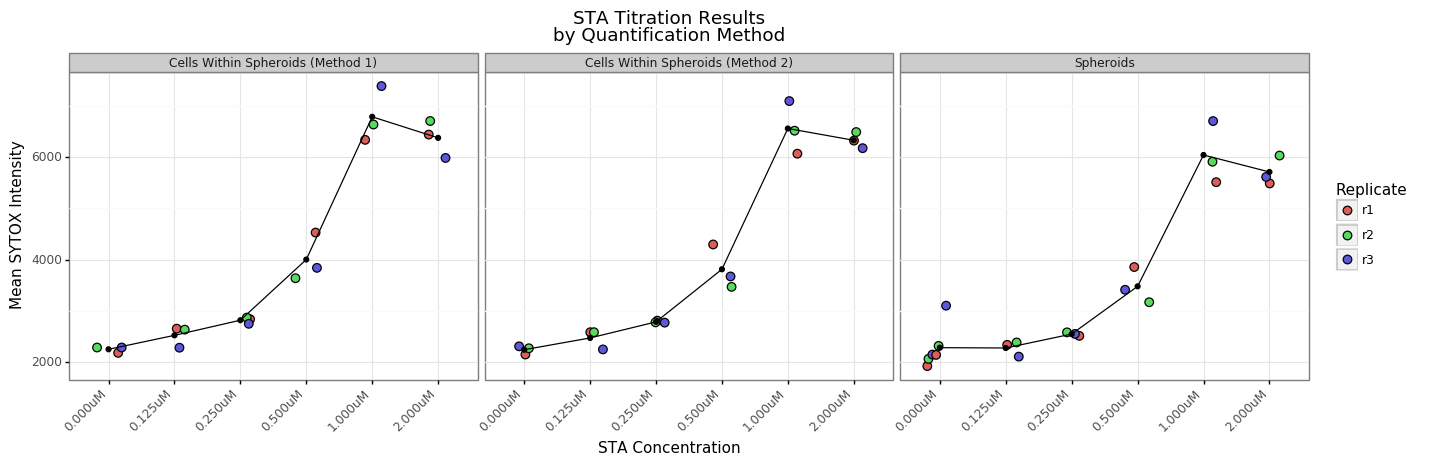

<ggplot: (8748922523105)>

In [4]:
def get_sta_titration_plot(df, methods=None):
    cols = ['exp_grp', 'exp_name', 'exp_sta_conc', 'exp_variant', 'exp_rep', 'obj', 'method']
    df = df[df['exp_grp'] == '20190703-sta-titration'].copy()
    
    def get_method(r):
        if r['obj'] == 'cell' and r['exp_variant'] == 'cpn-cell-only':
            return 'Cells Only'
        if r['obj'] == 'cell' and r['exp_variant'] == 'spheroid-cpn-cell':
            return 'Cells Within Spheroids (Method 1)'
        if r['obj'] == 'cell' and r['exp_variant'] == 'spheroid-dog-cell':
            return 'Cells Within Spheroids (Method 2)'
        if r['obj'] == 'spheroid' and r['exp_variant'] == 'spheroid-dog-cell':
            return 'Spheroids'
        return None
    df['method'] = df.apply(get_method, axis=1)
    # Ignore this one for now
    df = df[df['method'] != 'Cells Only']
    assert df['method'].notnull().all()
    
    if methods is not None:
        df = df[df['method'].isin(methods)]
    
    # Omit due to channels being switched in this condition (SYTOX is unstable so imaging last makes it dimmer)
    df = df[df['exp_sta_conc'] != '4.000uM'] 
    df = df.groupby(cols)['ci_SYTOX_mean'].mean().rename('value').reset_index()
    df = df.drop(['obj', 'exp_variant'], axis=1)
    df = df.rename(columns=lambda c: c.replace('exp_', ''))
    dfm = df.groupby(['sta_conc', 'method'])['value'].mean().rename('value').reset_index().assign(rep='r1')
    return df, (
        pn.ggplot(
            df,
            pn.aes(x='sta_conc', y='value', fill='rep', group=1)
        ) + 
        pn.facet_wrap('~ method', ncol=4) + 
        pn.geom_jitter(width=.2, size=3) + 
        pn.geom_point(data=dfm, fill='black') + 
        pn.geom_line(data=dfm, color='black') + 
        pn.labs(
            x='STA Concentration', y='Mean SYTOX Intensity', 
            title='STA Titration Results\nby Quantification Method',
            fill='Replicate'
        ) + 
        pn.theme_bw() + 
        pn.theme(figure_size=(16, 4), axis_text_x=pn.element_text(rotation=45, hjust=1))
    )

dfp, p = get_sta_titration_plot(dfa)
dfp[['sta_conc', 'value', 'rep', 'method']].reset_index(drop=True)\
    .to_csv('export/sta-titration.csv', index=False)
p

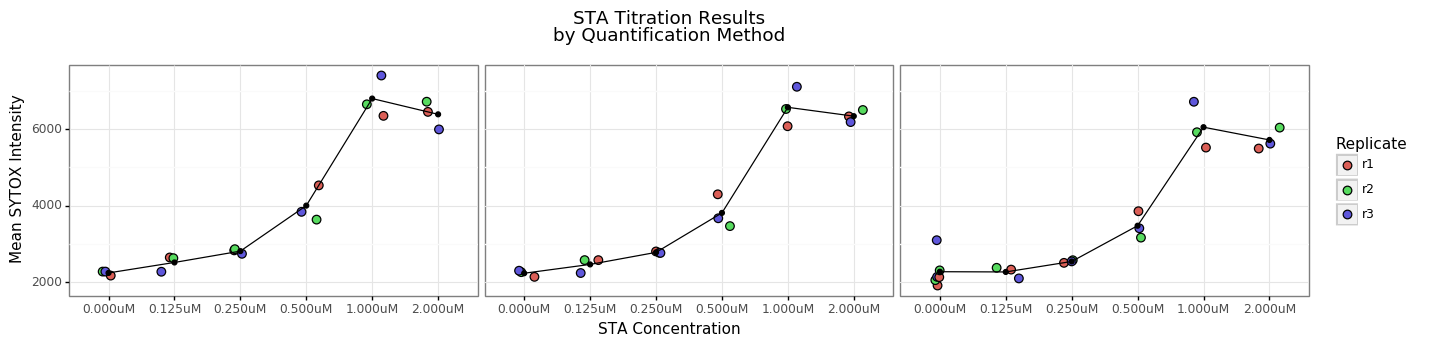

<ggplot: (8748925923837)>

In [5]:
p + pn.theme(
    figure_size=(16,3),
    axis_text_x=pn.element_text(rotation=0, hjust=0.5),
    strip_background=pn.element_blank(),
    strip_text_x=pn.element_blank()
)

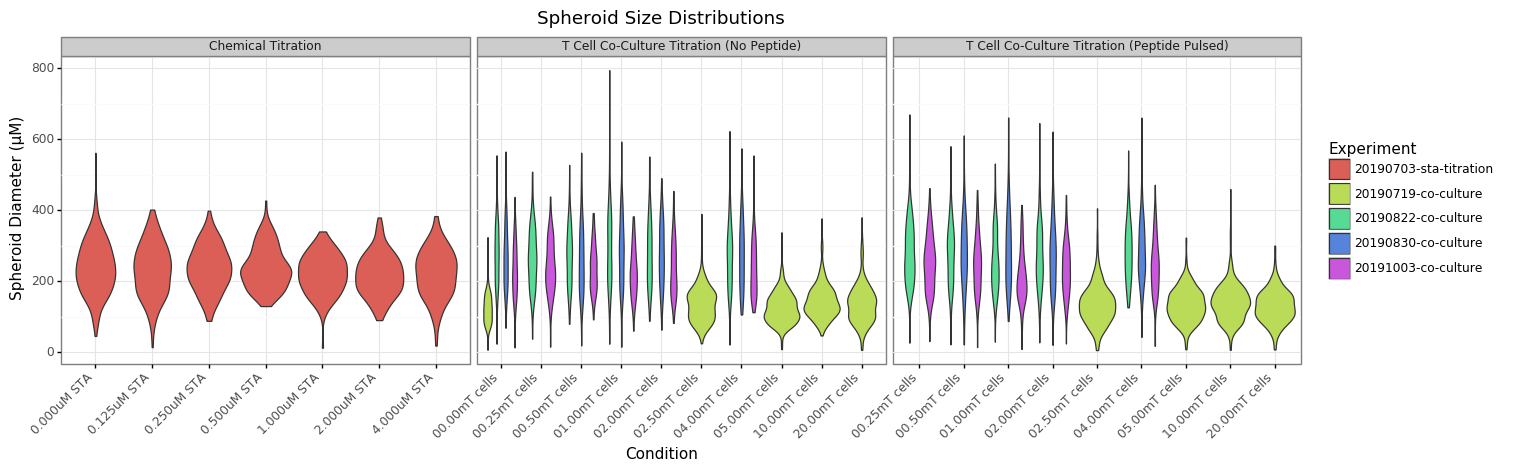

<ggplot: (-9223363287936018302)>

In [6]:
def get_spheroid_size_df(df):
    df = df[df['exp_variant'] == 'spheroid-dog-cell']
    df = df[df['obj'] == 'spheroid']
    df = df.copy()
    
    # Remove as T cell counts do not align with other replicates (it was also segmented with different spheroid classifier)
    # df = df[df['exp_grp'] != '20190719-co-culture']
    
    def get_treatment(r):
        if 'co-culture' in r['exp_grp'] and r['exp_has_peptide'] == 'No Peptide':
            return 'T Cell Co-Culture Titration (No Peptide)'
        if 'co-culture' in r['exp_grp'] and r['exp_has_peptide'] == 'w/ Peptide':
            return 'T Cell Co-Culture Titration (Peptide Pulsed)'
        if 'sta-titration' in r['exp_grp']:
            return 'Chemical Titration'
        return None
    df['treatment'] = df.apply(get_treatment, axis=1)
    assert df['treatment'].notnull().all()
    
    def get_label(r):
        if 'co-culture' in r['exp_grp']:
            return '{} cells'.format(r['exp_cell_count'])
        return '{} STA'.format(r['exp_sta_conc'])
    
    df['label'] = df.apply(get_label, axis=1)
    df = df.rename(columns={'cm_diameter': 'value'})
    return df

def get_spheroid_size_plot(df):
    df = get_spheroid_size_df(df)
    return df, (
        pn.ggplot(
            df,
            pn.aes(x='label', y='value', fill='exp_grp')
        ) + 
        pn.geom_violin() + 
        pn.facet_wrap('~ treatment', ncol=3, scales='free_x') + 
        pn.labs(x='Condition', y='Spheroid Diameter (μM)', fill='Experiment', title='Spheroid Size Distributions') + 
        pn.theme_bw() +
        pn.theme(figure_size=(16, 4), axis_text_x=pn.element_text(rotation=45, hjust=1))
    )
dfp, p = get_spheroid_size_plot(dfa)
dfp[['label', 'value', 'exp_grp', 'treatment']].reset_index(drop=True)\
    .to_csv('export/spheroid-size.csv', index=False)
p

In [7]:
dfp.head()

,cb_on_border,ci_BF_mean,ci_DRAQ7_mean,ci_HOECHST_mean,ci_ICYTE_mean,ci_SPHEROID_mean,ci_SYTOX_mean,cm_circularity,value,cm_diameter_vx,...,ry,tile_index,tile_x,tile_y,x,y,z,label1,treatment,label
649164,1,43374.545414,NaN,6866.289877,NaN,NaN,2593.773007,0.683447,333.664601,NaN,...,NaN,NaN,NaN,NaN,3091.061208,146.201921,0,00.00mT+0.125uM+No Peptide,Chemical Titration,0.125uM STA
649165,0,45404.965107,NaN,4548.724417,NaN,NaN,2130.855721,0.629329,173.109693,NaN,...,NaN,NaN,NaN,NaN,1626.598572,277.635962,0,00.00mT+0.125uM+No Peptide,Chemical Titration,0.125uM STA
649166,0,44614.996551,NaN,6582.557231,NaN,NaN,3388.401492,0.680441,287.486565,NaN,...,NaN,NaN,NaN,NaN,1259.464013,316.297141,0,00.00mT+0.125uM+No Peptide,Chemical Titration,0.125uM STA
649167,0,43919.692940,NaN,3886.453815,NaN,NaN,3199.107747,0.484023,195.023618,NaN,...,NaN,NaN,NaN,NaN,1964.688002,422.626942,0,00.00mT+0.125uM+No Peptide,Chemical Titration,0.125uM STA
649168,0,44172.603111,NaN,3261.868512,NaN,NaN,2507.081743,0.296294,248.530475,NaN,...,NaN,NaN,NaN,NaN,1836.766491,391.796834,0,00.00mT+0.125uM+No Peptide,Chemical Titration,0.125uM STA


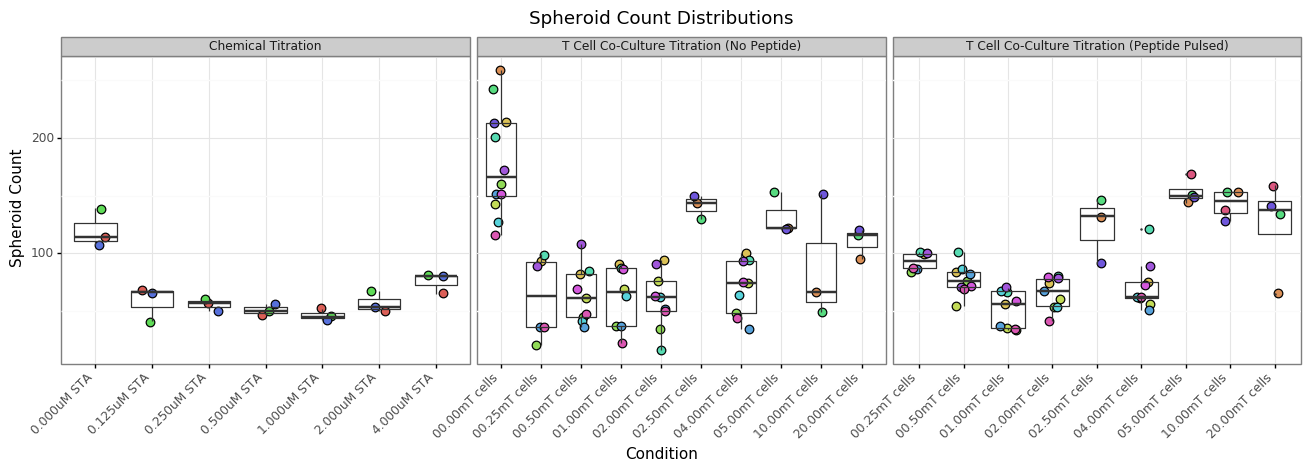

<ggplot: (-9223363287942346047)>

In [8]:
def get_spheroid_count_plot(df):
    df = get_spheroid_size_df(df)
    df = df.groupby(['exp_grp', 'label', 'exp_rep', 'treatment']).size().rename('value').reset_index()
    return df, (
        pn.ggplot(
            df,
            pn.aes(x='label', y='value', fill='exp_rep + exp_grp')
        ) + 
        pn.geom_jitter(width=.2, size=3) +
        pn.geom_boxplot(fill=None, outlier_size=0) + 
        pn.facet_wrap('~ treatment', ncol=3, scales='free_x') + 
        pn.guides(fill=None) + 
        pn.labs(x='Condition', y='Spheroid Count', fill='Group', title='Spheroid Count Distributions') + 
        pn.theme_bw() +
        pn.theme(figure_size=(16, 4), axis_text_x=pn.element_text(rotation=45, hjust=1))
    )
dfp, p = get_spheroid_count_plot(dfa)
dfp.reset_index(drop=True).to_csv('export/spheroid-count.csv')
p

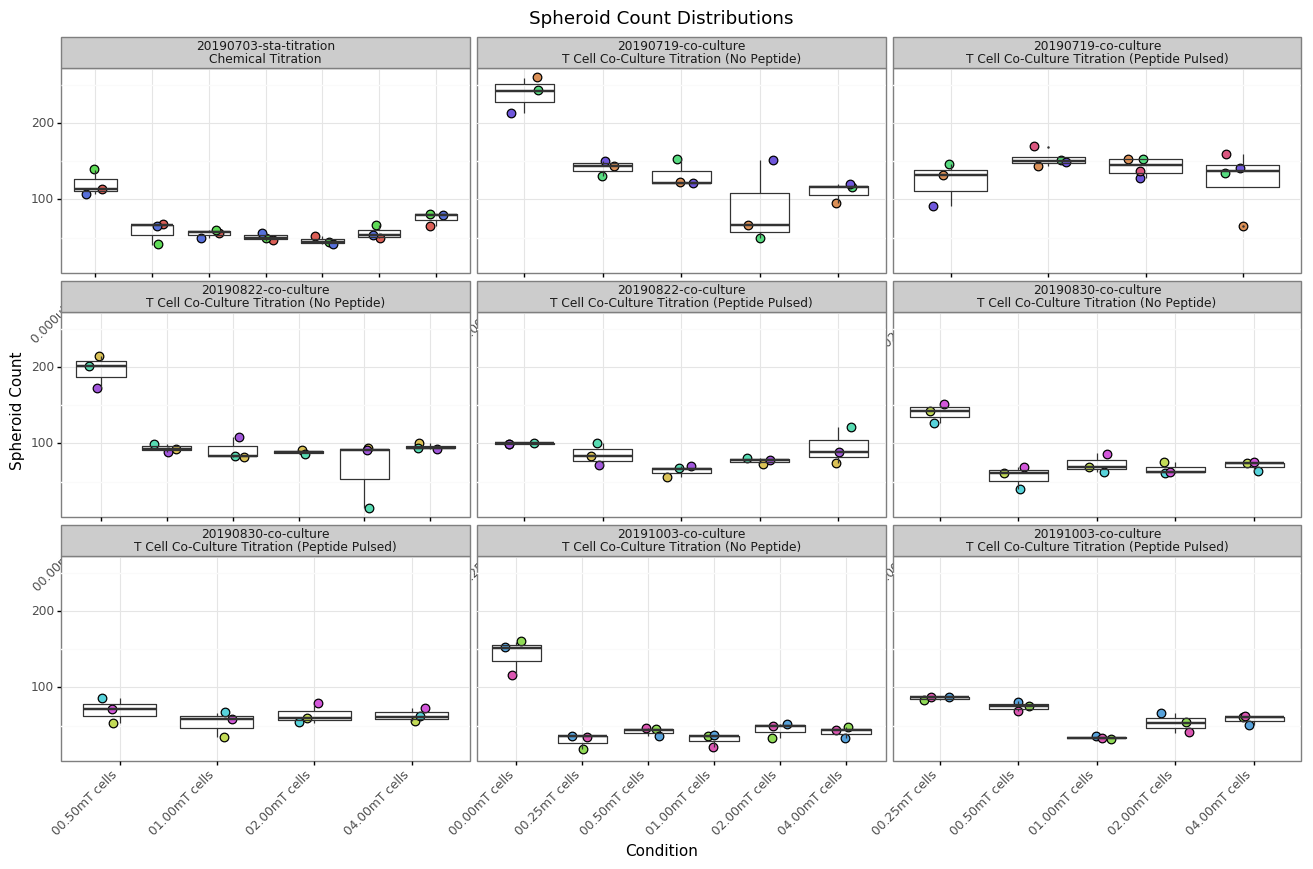

<ggplot: (8748925923669)>

In [9]:
p + pn.facet_wrap('~ exp_grp + treatment', ncol=3, scales='free_x') + pn.theme(figure_size=(16, 9))

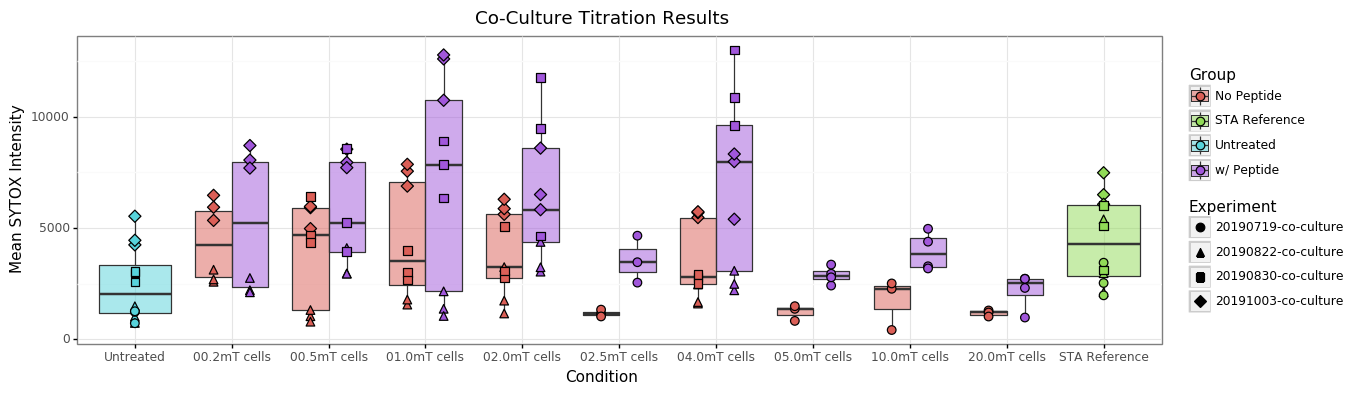

<ggplot: (8748912309182)>

In [10]:
def get_coculture_df(df, method):
    df = df[df['exp_grp'].str.contains('co-culture')]
    df = df.copy()
    
    def get_method(r):
        if r['obj'] == 'cell' and r['exp_variant'] == 'cpn-cell-only':
            return 'Cells Only'
        if r['obj'] == 'cell' and r['exp_variant'] == 'spheroid-cpn-cell':
            return 'Cells Within Spheroids (Method 1)'
        if r['obj'] == 'cell' and r['exp_variant'] == 'spheroid-dog-cell':
            return 'Cells Within Spheroids (Method 2)'
        if r['obj'] == 'spheroid' and r['exp_variant'] == 'spheroid-dog-cell':
            return 'Spheroids'
        return None
    df['method'] = df.apply(get_method, axis=1)
    df = df[df['method'] == method]
    
    df = df.groupby(['exp_grp', 'exp_has_peptide', 'exp_sta_conc', 'exp_cell_count', 'exp_rep'])['ci_SYTOX_mean'].mean().rename('value').reset_index()
    return df
    
def get_coculture_plot(df, method='Spheroids', rmrep=True):
    df = get_coculture_df(df, method)
    
    if rmrep:
        # Remove as T cell counts do not align with other replicates (it was also segmented with different spheroid classifier)
        df = df[df['exp_grp'] != '20190719-co-culture']
    
    def get_label(r):
        if float(r['exp_sta_conc'].replace('uM', '')) > 0: 
            return 'STA Reference'
        if float(r['exp_cell_count'].replace('mT', '')) > 0:
            return r['exp_has_peptide']
        if float(r['exp_cell_count'].replace('mT', '')) <= 0:
            return 'Untreated'
        raise ValueError('Invalid row {}'.format(r))
    df['label'] = df.apply(get_label, axis=1)
    
    def get_condition(r):
        if r['label'] == 'STA Reference':
            return 'STA Reference'
        if r['label'] == 'Untreated':
            return 'Untreated'
        return '{:04.1f}mT cells'.format(float(r['exp_cell_count'].replace('mT', '')))
    df['condition'] = df.apply(get_condition, axis=1)
    vals = set(df['condition'].unique()) - set(['Untreated', 'STA Reference'])
    df['condition'] = pd.Categorical(df['condition'], ordered=True, categories=['Untreated'] + sorted(list(vals)) + ['STA Reference'])
    return df, (
        pn.ggplot(
            df,
            pn.aes(x='condition', y='value', fill='label')
        ) + 
        pn.geom_boxplot(alpha=.5) + 
        pn.geom_point(position=pn.position_dodge(width=.75), size=3, mapping=pn.aes(shape='exp_grp', group='exp_has_peptide')) + 
        pn.labs(x='Condition', y='Mean SYTOX Intensity', fill='Group', shape='Experiment', title='Co-Culture Titration Results') + 
        pn.theme_bw() + 
        pn.theme(figure_size=(14, 4))
    )
    
dfp, p0 = get_coculture_plot(dfa, method='Spheroids', rmrep=False)
dfp.reset_index(drop=True).to_csv('export/co-culture-titration.csv')
p0

In [11]:
_, p1 = get_coculture_plot(dfa, method='Spheroids')
_, p2 = get_coculture_plot(dfa, method='Cells Within Spheroids (Method 1)')
_, p3 = get_coculture_plot(dfa, method='Cells Within Spheroids (Method 2)')
ylim = pn.ylim(0, 22000)

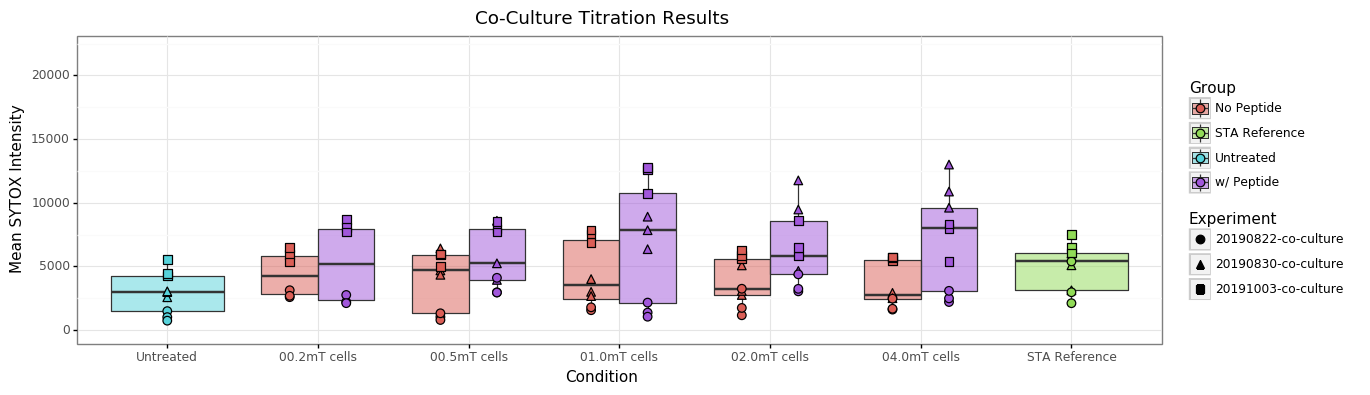

<ggplot: (8748888582797)>

In [12]:
p1 + ylim

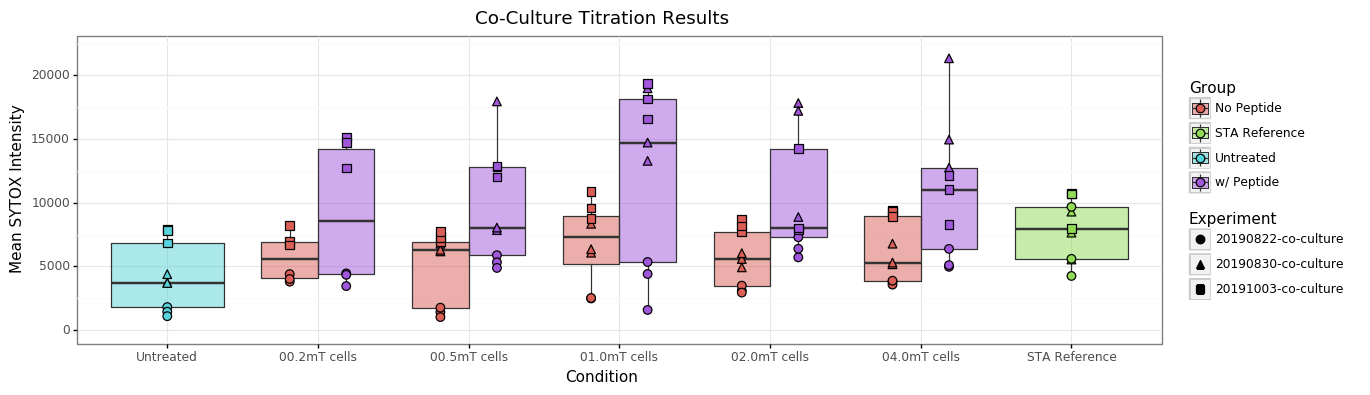

<ggplot: (-9223363287966808071)>

In [13]:
p2 + ylim

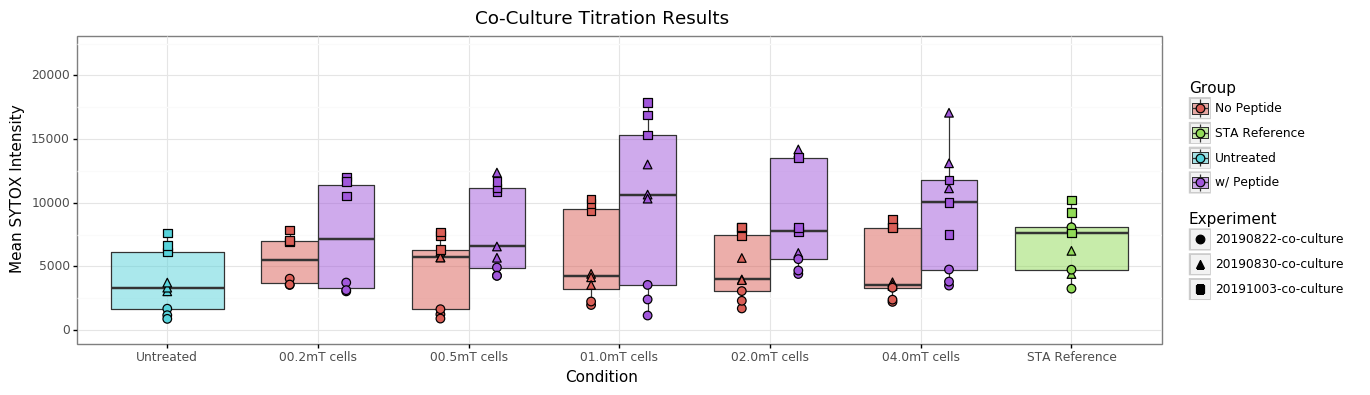

<ggplot: (8748887967601)>

In [14]:
p3 + ylim

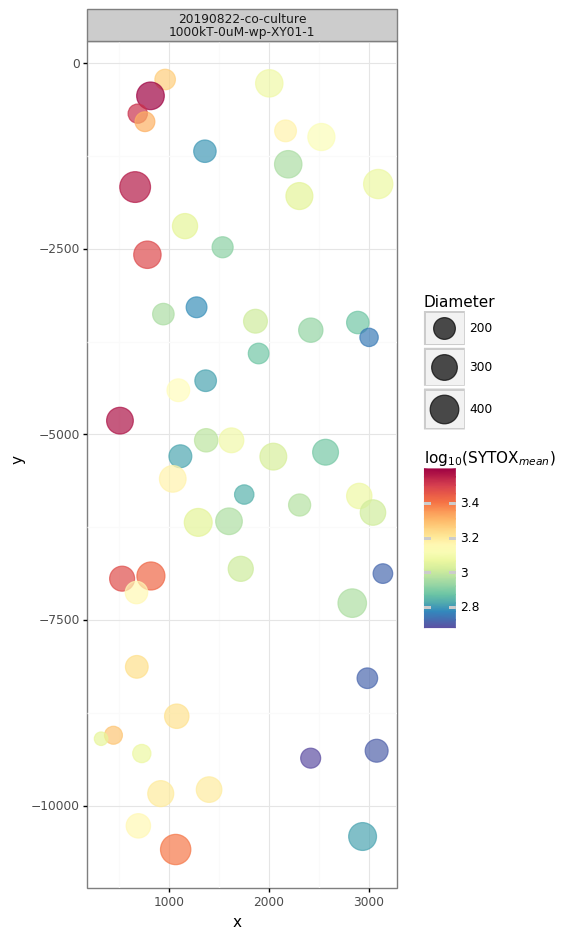

<ggplot: (8748922502152)>

In [15]:
def get_spheroid_plot(df):
    df = df[df['exp_grp'].str.contains('co-culture')]
    df = df[df['exp_variant'] == 'spheroid-dog-cell']
    df = df[df['obj'] == 'spheroid']
    df = df[df['exp_name'].isin(['1000kT-0uM-wp-XY01-1']) & (df['exp_grp'] == '20190822-co-culture')]
    df = df.copy()[['exp_grp', 'obj', 'exp_name', 'x', 'y', 'rx', 'ry', 'ci_SYTOX_mean', 'cm_diameter']]
    
    def trans(df):
        return df.assign(ci_SYTOX_mean=lambda df: df['ci_SYTOX_mean'].apply(np.log10).clip(0, 4))
    return (
        pn.ggplot(
            df.pipe(trans),
            pn.aes(x='x', y='-1*y', fill='ci_SYTOX_mean', color='ci_SYTOX_mean', size='cm_diameter')
        ) + 
        pn.geom_point(alpha=.7) + 
        pn.scale_size_continuous(range=(5, 12)) + 
        pn.scale_fill_cmap('Spectral_r') + 
        pn.scale_color_cmap('Spectral_r') + 
        pn.facet_wrap('~exp_grp + exp_name') + 
        pn.labs(y='y', x='x', size='Diameter', fill='log$_{10}$(SYTOX$_{mean}$)', color='log$_{10}$(SYTOX$_{mean}$)') + 
        pn.theme_bw() + 
        # Use aspect ratio of grid image (approx 2.75 to 1)
        pn.theme(figure_size=(4, 4*2.75))
        
    )
get_spheroid_plot(dfa)

In [16]:
dfa['exp_sta_conc'].unique()

array(['0.125uM', '0.250uM', '0.500uM', '1.000uM', '2.000uM', '4.000uM',
       '0.000uM'], dtype=object)

In [32]:
def get_decay_plot(df, mode='co-culture'):
    if mode == 'co-culture':
        # Co-culture focus
        df = df[df['exp_grp'].str.contains('co-culture')]

        # Remove this experiment because the channels were swapped in some of the images 
        # (i.e. T cells on right side instead of left)
        # df = df[~df['exp_grp'].str.contains('20190830-co-culture')]

        # Ignore any STA conditions
        # df = df[df['exp_sta_conc'] != '4.000uM']
    
        # Choose conditions with at least some number of T cells
        # df = df[df['exp_cell_count'].str.replace('mT', '').apply(float) > 0]
    elif mode == 'sta-titration':
        df = df[df['exp_grp'].str.contains('sta-titration')]
    else:
        raise ValueError('Mode {} not valid'.format(mode))
        
    
    # Choose single calculation method and object to quantify
    df = df[df['exp_variant'] == 'spheroid-dog-cell']
    df = df[df['obj'] == 'spheroid']
    
    df = df.copy()[[
        'exp_grp', 'obj', 'exp_name', 'x', 'y', 'exp_sta_conc', 
        'exp_has_peptide', 'exp_rep',
        'exp_cell_count', 'ci_SYTOX_mean', 'cm_diameter']
    ].reset_index(drop=True)
    
    # Use 20190719 replicates in bin calculation separately since the images
    # were half the size, making the x bins smaller
    if mode == 'co-culture':
        m1 = pd.cut(df[df['exp_grp'] == '20190719-co-culture']['x'], bins=10)
        m1 = pd.Series(m1.cat.codes, index=m1.index).to_dict()
        m2 = pd.cut(df[df['exp_grp'] != '20190719-co-culture']['x'], bins=10)
        m2 = pd.Series(m2.cat.codes, index=m2.index).to_dict()
        df['xbin'] = pd.Series(df.index.values).map({**m1, **m2}).apply('{:02d}'.format)
    else:
        m1 = pd.cut(df['x'], bins=10)
        m1 = pd.Series(m1.cat.codes, index=m1.index).to_dict()
        df['xbin'] = pd.Series(df.index.values).map(m1).apply('{:02d}'.format)
    
    def trans(df):
        return df.assign(ci_SYTOX_mean=lambda df: df['ci_SYTOX_mean'].apply(np.log10).clip(0, 4))
    # Aggregate acrosss experimental replicates
    df = df.pipe(trans).groupby([
        'exp_grp', 'exp_name', 'exp_has_peptide', 'exp_sta_conc', 
        'exp_cell_count', 'exp_rep', 'xbin'
    ])['ci_SYTOX_mean'].mean().rename('value').reset_index()
    
    # Get distribution across entire experiment group
    dfp = df.groupby(['exp_grp', 'exp_has_peptide', 'xbin'])['value'].describe().reset_index()
    return df, (
        pn.ggplot(
            dfp.assign(ymin=lambda df: df['25%'], ymax=lambda df: df['75%']),
            pn.aes(
                x='xbin', y='mean', fill='exp_grp', color='exp_grp', 
                group='exp_has_peptide+exp_grp', linetype='exp_has_peptide')
        ) + 
        pn.geom_point(position=pn.position_dodge(width=.3), size=3) + 
        pn.geom_line(position=pn.position_dodge(width=.3)) +
        pn.geom_errorbar(mapping=pn.aes(ymin='25%', ymax='75%'), position=pn.position_dodge(width=.3), width=.3) + 
        pn.labs(fill='Experiment', color='Experiment', linetype='Has Peptide', 
                x='X Range Index', y='log$_{10}$(SYTOX$_{mean}$)') + 
        pn.theme_bw() + 
        pn.theme(figure_size=(4, 2), axis_text_x=pn.element_text(rotation=0))
        
    )

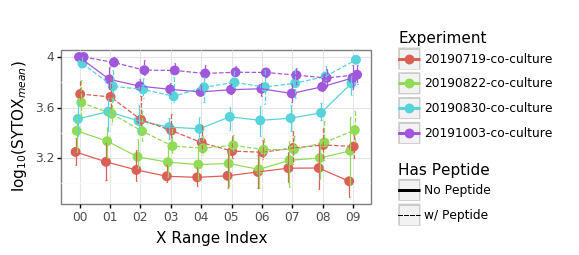

<ggplot: (-9223363287966239088)>

In [33]:
dfp1, p1 = get_decay_plot(dfa, mode='co-culture')
dfp2, p2 = get_decay_plot(dfa, mode='sta-titration')
dfp = pd.concat([dfp1, dfp2]).reset_index(drop=True)
assert len(dfp.drop_duplicates()) == len(dfp1) + len(dfp2)
dfp.to_csv('export/horizontal-bias.csv')
p1

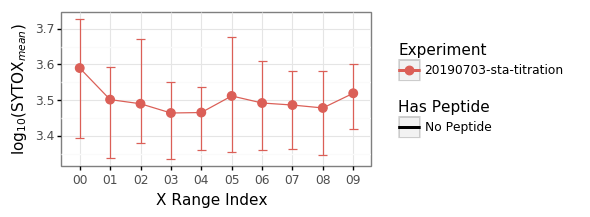

<ggplot: (8748888520035)>

In [34]:
p2

In [35]:
dfp.head()

,exp_grp,exp_name,exp_has_peptide,exp_sta_conc,exp_cell_count,exp_rep,xbin,value
0,20190719-co-culture,00.0mT-np-0uMsta-XY01-1,No Peptide,0.000uM,00.00mT,r1,00,3.142806
1,20190719-co-culture,00.0mT-np-0uMsta-XY01-1,No Peptide,0.000uM,00.00mT,r1,01,3.029823
2,20190719-co-culture,00.0mT-np-0uMsta-XY01-1,No Peptide,0.000uM,00.00mT,r1,02,3.114561
3,20190719-co-culture,00.0mT-np-0uMsta-XY01-1,No Peptide,0.000uM,00.00mT,r1,03,3.016470
4,20190719-co-culture,00.0mT-np-0uMsta-XY01-1,No Peptide,0.000uM,00.00mT,r1,04,3.044660


In [36]:
dfp['exp_grp'].value_counts()

20190822-co-culture       320
20190719-co-culture       300
20191003-co-culture       288
20190830-co-culture       246
20190703-sta-titration    225
Name: exp_grp, dtype: int64

## EDA

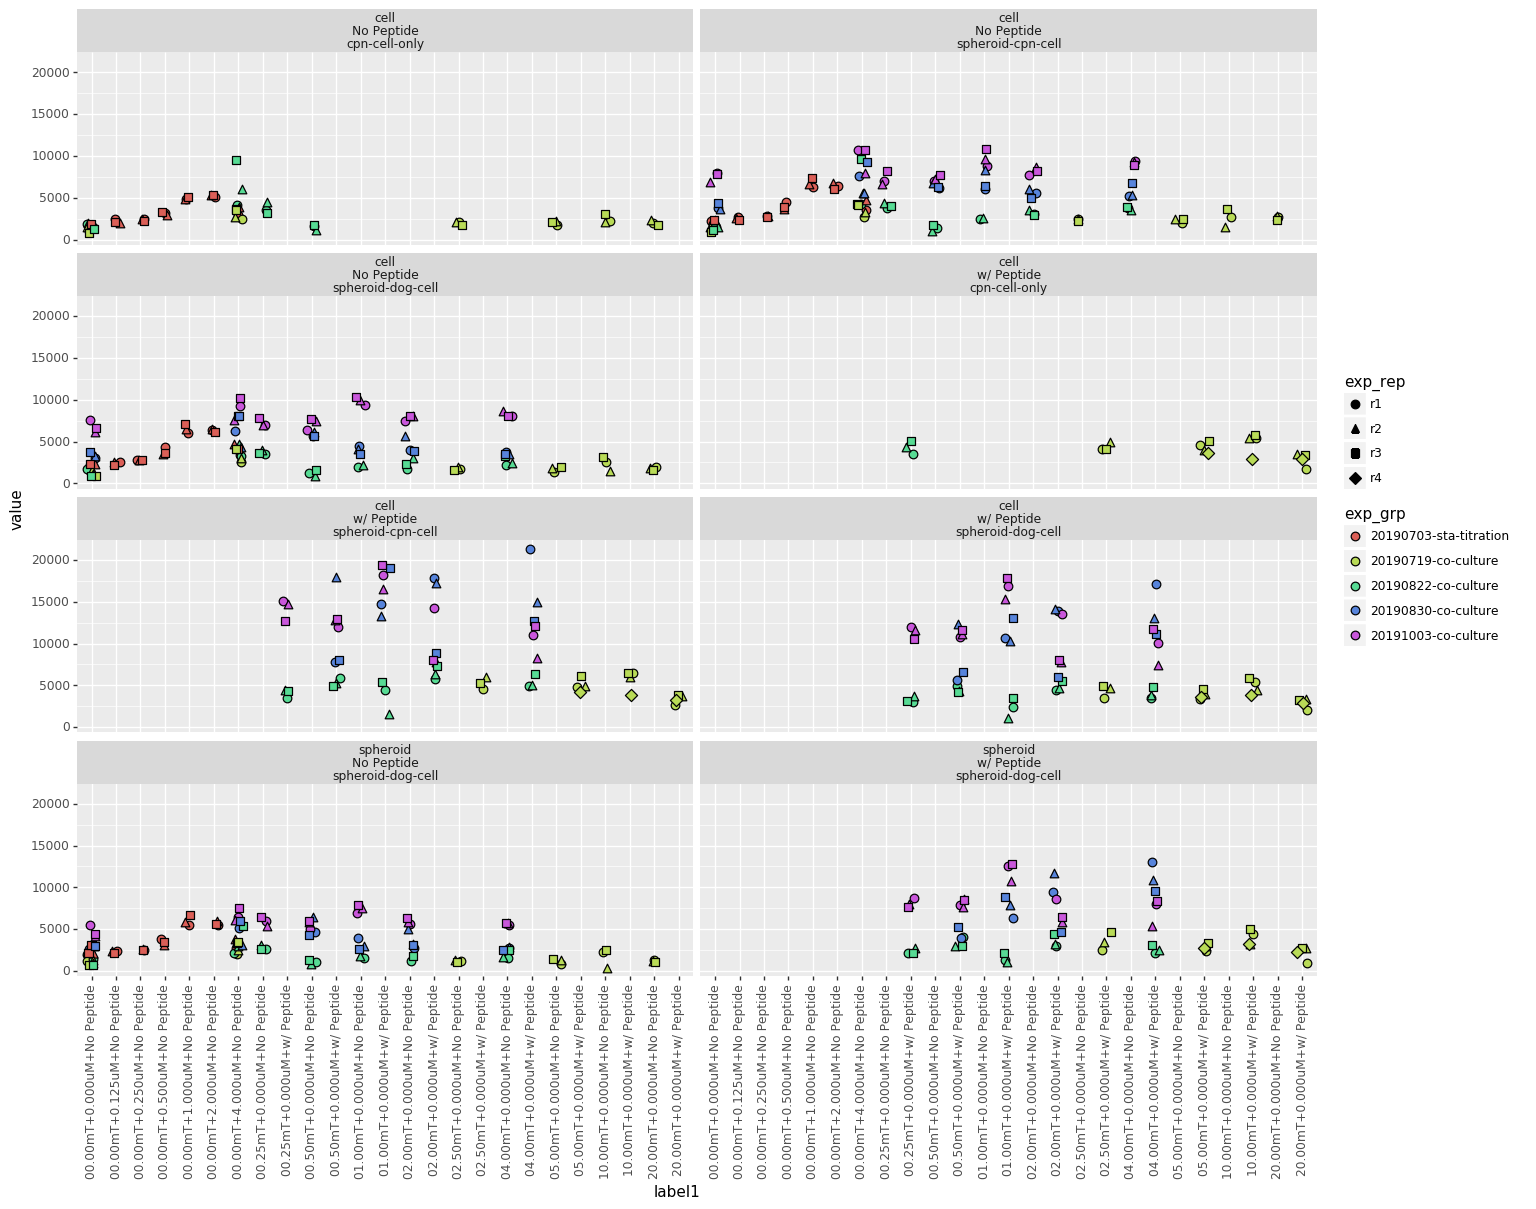

<ggplot: (8782896612160)>

In [50]:
cols = ['exp_grp', 'exp_name', 'label1', 'exp_cell_count', 'exp_sta_conc', 'exp_has_peptide', 'exp_rep', 'exp_variant', 'obj']
(
    pn.ggplot(
        dfa.groupby(cols)['ci_SYTOX_mean'].mean().rename('value').reset_index(),
        pn.aes(x='label1', y='value', fill='exp_grp', shape='exp_rep')
    ) + 
    pn.facet_wrap('~ obj + exp_has_peptide + exp_variant', ncol=2) + 
    pn.geom_jitter(width=.2, size=3) + 
    pn.theme(figure_size=(16, 12), axis_text_x=pn.element_text(rotation=90))
)